In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

In [2]:
import astropy.units as u 

In [3]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [4]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  335.585 GB
     percent :   33.300 % 
        used :  130.061 GB
        free :  233.274 GB
      active :   17.503 GB
    inactive :  186.895 GB
     buffers :  134.543 MB
      cached :  139.672 GB
      shared :   11.013 GB
        slab :   30.240 GB



1. Start by creating a focalplane with a sample rate and number of detectors

In [5]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=4
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

In [6]:
with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

Define the schedule, site and telescope

In [8]:
schedule = toast.schedule.GroundSchedule()
schedule.read("POLE_DEEP-169-7.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP-169-7.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP-169-7.txt totaling 84.0 minutes.


In [9]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

In [10]:
telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [11]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [12]:
data = toast.Data(comm=toast_comm)

In [13]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [14]:
sim_ground.apply(data)

In [15]:
data.obs[0]
## Session associated to weather simulation, not individual optic tubes

<Observation
  name = 'POLE_DEEP-169-7'
  uid = '2008944542'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 15, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>
  session = <Session 'POLE_DEEP-169-7': uid = 1708650531, start = 2027-05-28 15:00:00+00:00, end = 2027-05-28 16:23:59.900000+00:00>
  scan_el = 54.1 deg
  scan_min_az = -1.2787014485740134 rad
  scan_max_az = 6.263463086632051 rad
  scan_min_el = 0.9442231253289323 rad
  scan_max_el = 0.9442231253289323 rad
  50400 total samples (50400 local)
  shared:  <SharedDataManager
    times (column): shape=(50400,), dtype=float64
    posit

In [16]:
noise_model = toast.ops.DefaultNoiseModel()
sim_noise = toast.ops.SimNoise() ###Need to instantiate Noise Model

In [17]:
sim_noise

<SimNoise
  API = 0 # Internal interface version for this operator
  component = 0 # The noise component index
  det_data = signal # Observation detdata key for accumulating noise timestreams
  det_data_units = K # Output units if creating detector data
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = SimNoise # The 'name' of this class instance
  noise_model = noise_model # Observation key containing the noise model
  realization = 0 # The noise realization index
  serial = True # Use legacy serial implementation instead of batched
  times = times # Observation shared key for timestamps
>

In [18]:
noise_model.apply(data) ## Read detector noise from the focalplane
sim_noise.apply(data)

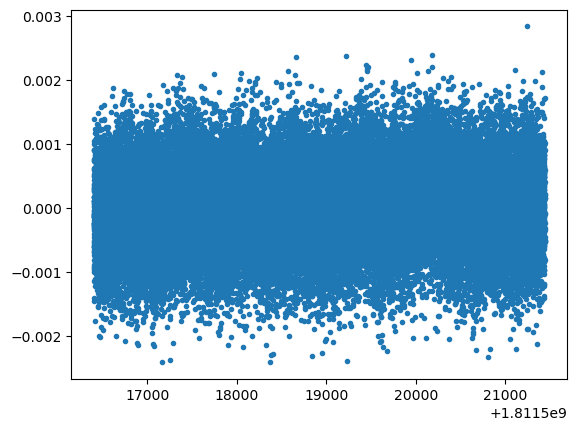

In [19]:
ob = data.obs[0]
plt.plot(ob.shared["times"],ob.detdata["signal"][0],".") ##Detdata has several data, signal is under "signal", detdata is a 2D array

In [20]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "IQU")
pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = 64)

In [21]:
binner = toast.ops.BinMap(pixel_pointing = pixels, stokes_weights = weights)
mapmaker = toast.ops.MapMaker(binning = binner)

In [22]:
mapmaker.apply(data)

TOAST INFO: MapMaker  finished template amplitude solve in 0.00 s
TOAST INFO: MapMaker Caching pixel distribution
TOAST INFO: MapMaker  finished build of pixel distribution in 0.54 s
TOAST INFO: MapMaker begin build of final binning covariance
TOAST INFO: MapMaker  finished build of final covariance in 1.61 s
TOAST INFO: Wrote ./MapMaker_hits.fits in 0.01 s
TOAST INFO: Wrote ./MapMaker_rcond.fits in 0.01 s
TOAST INFO: MapMaker begin map binning
TOAST INFO: MapMaker  finished binning in 13.50 s
TOAST INFO: Wrote ./MapMaker_binmap.fits in 0.01 s
TOAST INFO: MapMaker begin final map binning
TOAST INFO: MapMaker  finished final binning in 13.67 s
TOAST INFO: Wrote ./MapMaker_map.fits in 0.01 s
TOAST INFO: Wrote ./MapMaker_cov.fits in 0.01 s
TOAST INFO: MapMaker  finished output write in 0.02 s


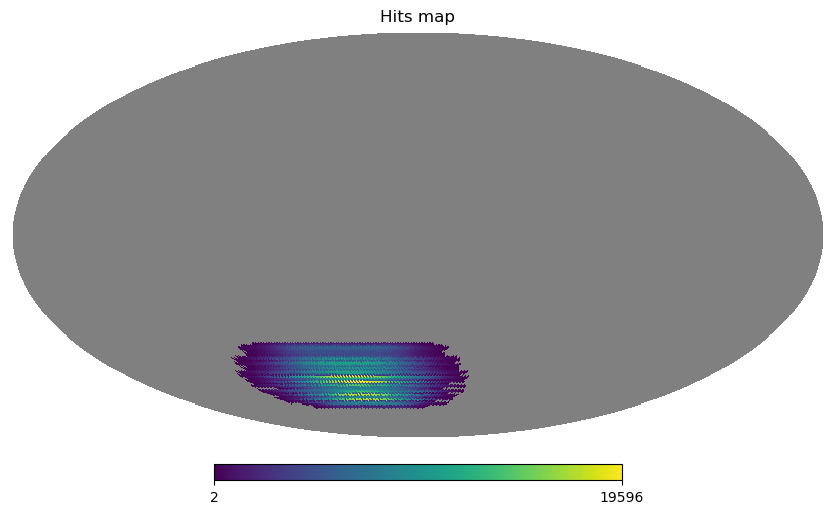

In [23]:
m = hp.read_map("MapMaker_hits.fits", dtype = float)
m[m==0] = hp.UNSEEN
hp.mollview(m, title =  "Hits map")


In [24]:
m.shape

(49152,)

In [25]:
m2 = hp.read_map("MapMaker_map.fits", dtype = float, field = None)
m2[m2==0] = hp.UNSEEN

In [26]:
m2.shape

(3, 49152)

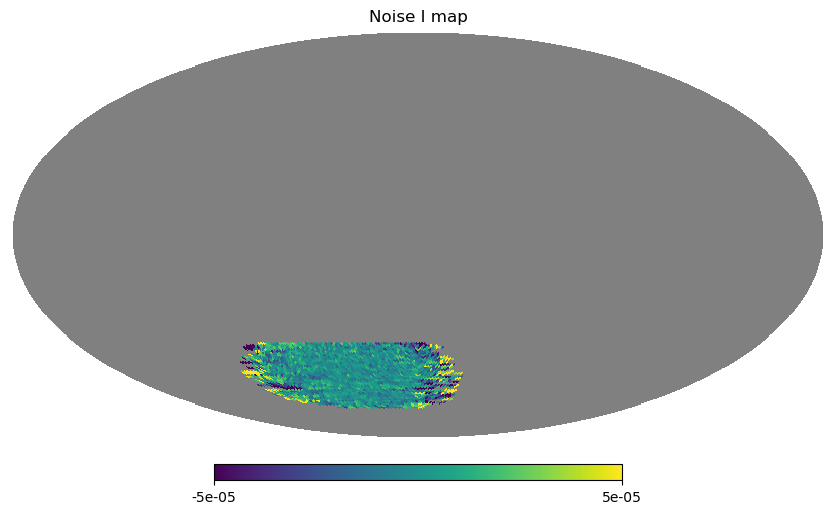

In [27]:
hp.mollview(m2[0], title =  "Noise I map", max = 5e-5,min = -5e-5)

In [28]:
m3 = hp.read_map("MapMaker_cov.fits", dtype = float, field = None)
m3 = 1/m3
m3[m3==0] = hp.UNSEEN

/tmp/ipykernel_1642553/964760892.py:2: RuntimeWarning: divide by zero encountered in divide
  m3 = 1/m3


In [29]:
m3.shape

(6, 49152)

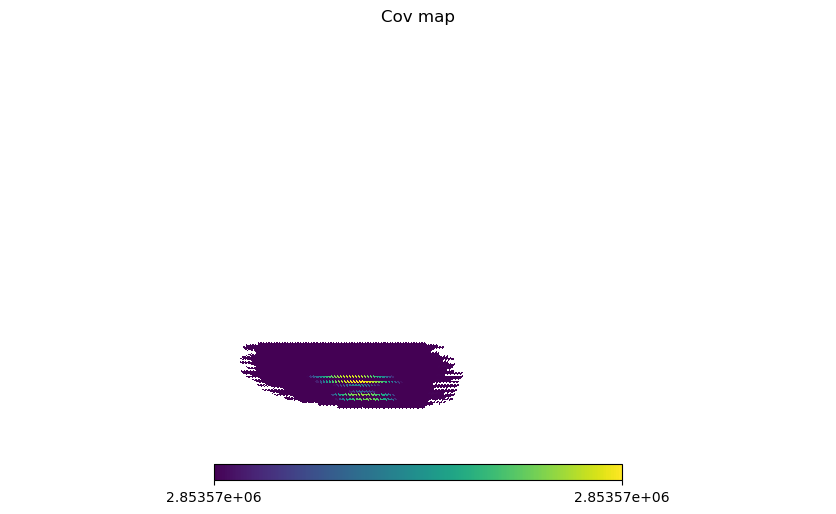

In [30]:
hp.mollview((m3/m)[0], title =  "Cov map"#, max = 5e-5,min = -5e-5
           )

In [31]:
hpointing = toast.ops.PointingDetectorSimple(boresight = 'boresight_azel')

In [32]:
hpointing

<PointingDetectorSimple
  API = 0 # Internal interface version for this operator
  boresight = boresight_azel # Observation shared key for boresight
  coord_in = None # The input boresight coordinate system ('C', 'E', 'G')
  coord_out = None # The output coordinate system ('C', 'E', 'G')
  det_mask = 1 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = PointingDetectorSimple # The 'name' of this class instance
  quats = quats # Observation detdata key for output quaternions
  shared_flag_mask = 1 # Bit mask value for optional flagging
  shared_flags = flags # Observation shared key for telescope flags to use
  view = None # Use this view of the data in all observations
>

In [33]:
#pointing.boresight = sim_ground.boresight_azel

In [34]:
sim_atmosphere = toast.ops.SimAtmosphere(detector_pointing=hpointing, detector_weights= weights)

In [35]:
sim_atmosphere

<SimAtmosphere
  API = 0 # Internal interface version for this operator
  add_loading = True # Add elevation-dependent loading.
  cache_dir = None # Directory to use for loading / saving atmosphere realizations
  cache_only = False # If True, only cache the atmosphere, do not observe it.
  component = 123456 # The component index to use for this atmosphere simulation
  debug_plots = False # If True, make plots of the debug snapshots
  debug_snapshots = False # If True, dump snapshots of the atmosphere slabs to pickle files
  debug_spectrum = False # If True, dump out Kolmogorov debug files
  debug_tod = False # If True, dump TOD to pickle files
  det_data = signal # Observation detdata key for accumulating atmosphere timestreams
  det_data_units = K # Output units if creating detector data
  det_flag_mask = 1 # Bit mask value for detector sample flagging
  det_flags = flags # Observation detdata key for flags to use
  det_mask = 1 # Bit mask value for per-detector flagging
  detector_p

In [36]:
sim_atmosphere.apply(data)

In [37]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-7'
  uid = '2008944542'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 15, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>
  session = <Session 'POLE_DEEP-169-7': uid = 1708650531, start = 2027-05-28 15:00:00+00:00, end = 2027-05-28 16:23:59.900000+00:00>
  scan_el = 54.1 deg
  scan_min_az = -1.2787014485740134 rad
  scan_max_az = 6.263463086632051 rad
  scan_min_el = 0.9442231253289323 rad
  scan_max_el = 0.9442231253289323 rad
  noise_model = <AnalyticNoise model with 252 detectors>
  50400 total samples (50400 local)
  sha

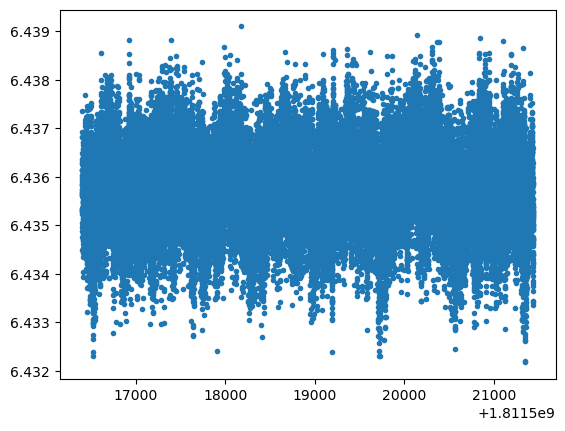

In [38]:
plt.plot(ob.shared["times"],ob.detdata["signal"][0],".") ##Detdata has several data, signal is under "signal", detdata is a 2D array

In [39]:
mapmaker.apply(data)

TOAST INFO: MapMaker  finished template amplitude solve in 0.00 s
TOAST INFO: MapMaker begin build of final binning covariance
TOAST INFO: MapMaker  finished build of final covariance in 1.68 s
TOAST INFO: Wrote ./MapMaker_hits.fits in 0.01 s
TOAST INFO: Wrote ./MapMaker_rcond.fits in 0.01 s
TOAST INFO: MapMaker begin map binning
TOAST INFO: MapMaker  finished binning in 13.59 s
TOAST INFO: Wrote ./MapMaker_binmap.fits in 0.01 s
TOAST INFO: MapMaker begin final map binning
TOAST INFO: MapMaker  finished final binning in 13.64 s
TOAST INFO: Wrote ./MapMaker_map.fits in 0.01 s
TOAST INFO: Wrote ./MapMaker_cov.fits in 0.01 s
TOAST INFO: MapMaker  finished output write in 0.03 s


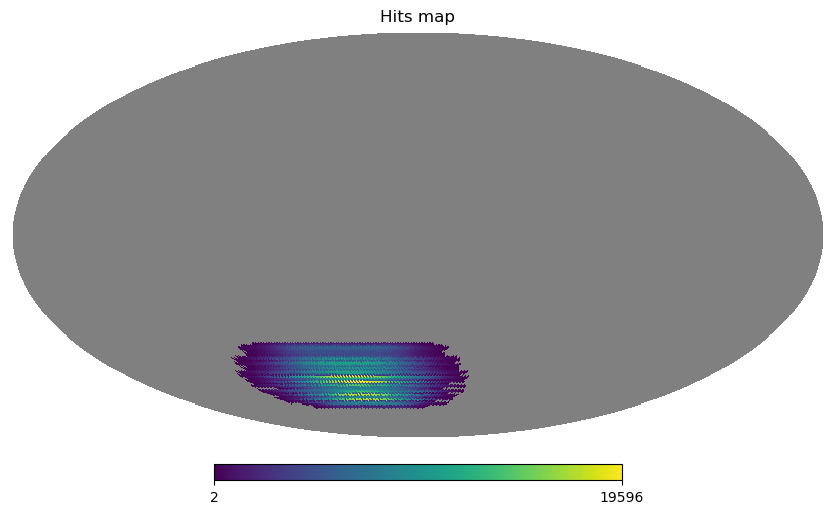

In [40]:
m = hp.read_map("MapMaker_hits.fits", dtype = float)
m[m==0] = hp.UNSEEN
hp.mollview(m, title =  "Hits map")


In [41]:
hit_mask = np.array(np.where(m<=0))[0]
mask = np.ones(m.shape,dtype = np.float64)

In [42]:
mask.shape

(49152,)

In [43]:
mask[hit_mask] = 0

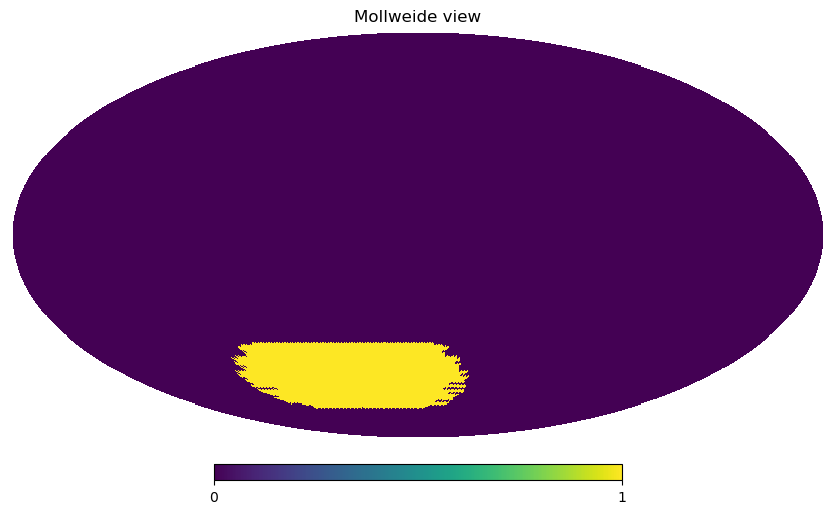

In [44]:
hp.mollview(mask)

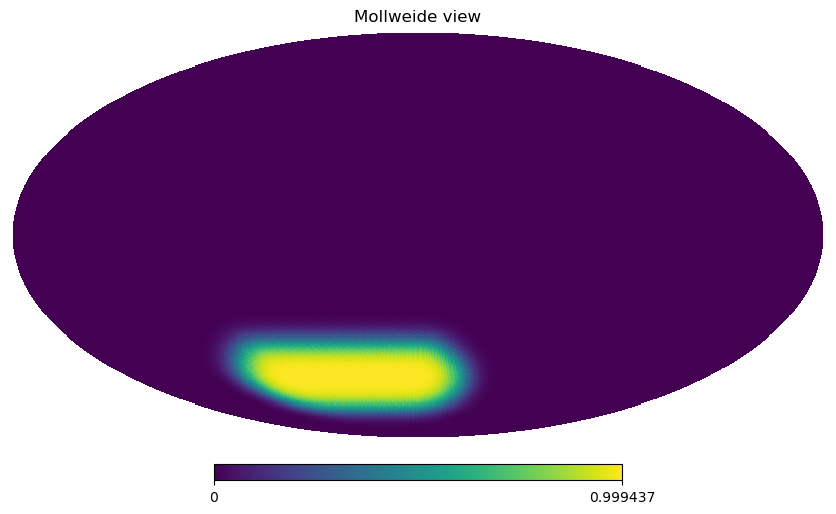

In [45]:
apodized_mask = np.clip(hp.smoothing(mask, fwhm=np.radians(10)), 0, None)
hp.mollview(apodized_mask)

In [46]:
m_atm = hp.read_map("MapMaker_map.fits", dtype = float, field = None)
m_atm[:] *= apodized_mask
m_atm[:,hit_mask] = hp.UNSEEN

In [47]:
NSIDE = 64
lmax = 2*NSIDE

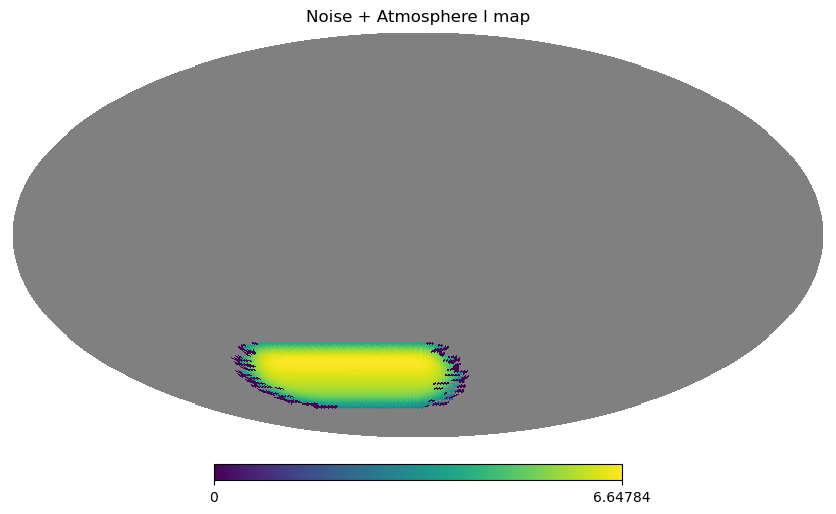

In [48]:
hp.mollview(m_atm[0], title =  "Noise + Atmosphere I map")

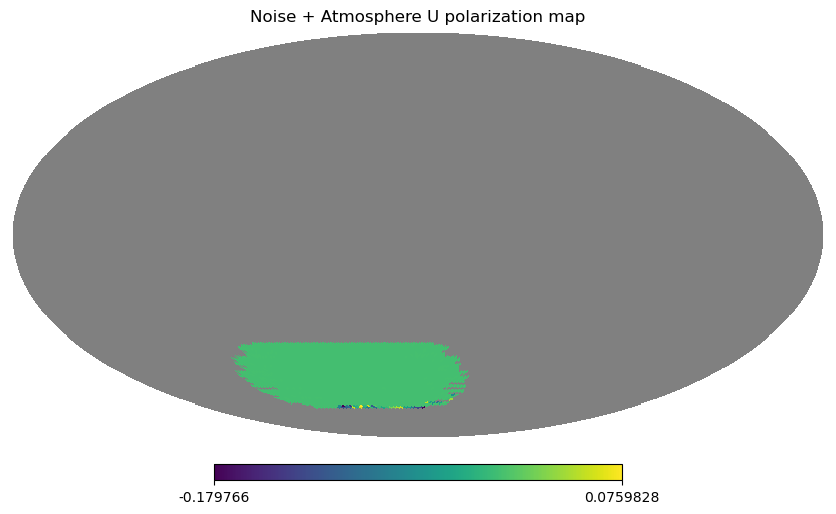

In [49]:
hp.mollview(m_atm[2], title =  "Noise + Atmosphere U polarization map")

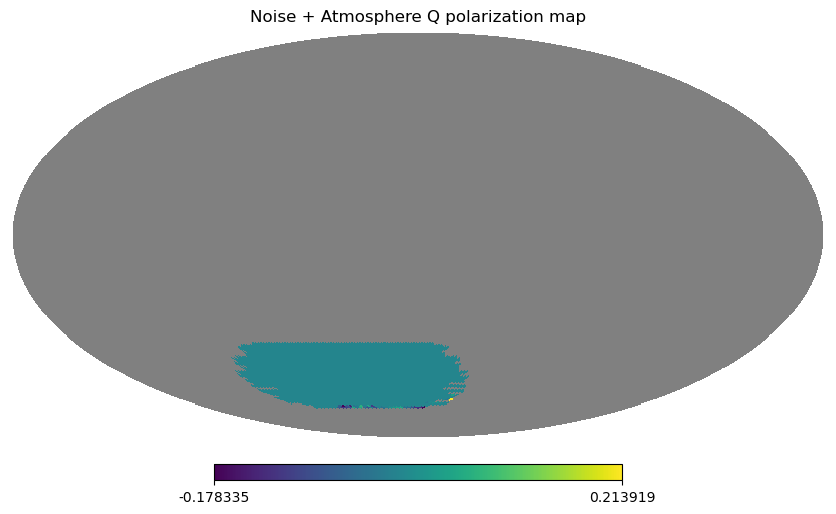

In [50]:
hp.mollview(m_atm[1], title =  "Noise + Atmosphere Q polarization map")

In [51]:
cls_atm = hp.anafast(m_atm, lmax=lmax,use_pixel_weights=True)

In [52]:
cls_atm.shape

(6, 129)

In [53]:
l_arr = np.arange(0,lmax+1)
l_arr.shape

(129,)

In [54]:
dls_atm = cls_atm[:]*l_arr*(l_arr+1)/(2*np.pi)

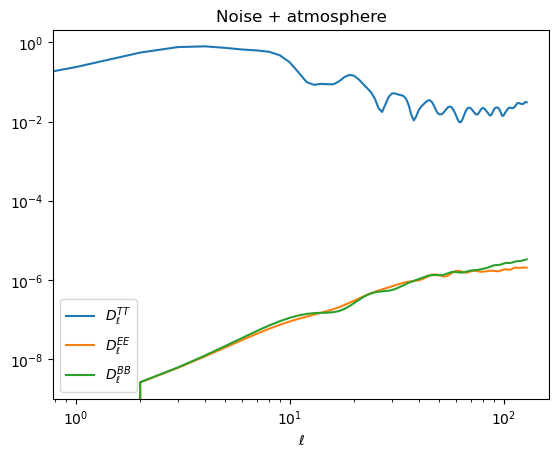

In [55]:
plt.plot(l_arr, dls_atm[0], label = r'$D_{\ell}^{TT}$')
plt.plot(l_arr, dls_atm[1], label = r'$D_{\ell}^{EE}$')
plt.plot(l_arr, dls_atm[2], label = r'$D_{\ell}^{BB}$')
plt.xlabel('$\ell$')
plt.legend(loc = 'best')
plt.xscale('log')
plt.yscale('log')
plt.title('Noise + atmosphere')
plt.show()